In [1]:
%matplotlib widget
from typing import Callable, Optional
from dataclasses import dataclass

In [2]:
import numpy as np
import sympy
import matplotlib.pyplot as plt

In [3]:
from montecarlo import MonteCarloEstimate, monte_carlo

# Control variates
Alex Gorodetsky, September 2020,
Updated January, 2024

Consider trying to integrate $$I_g = \int_0^1 g(x) dx, \quad g(x) = \frac{1}{1+x}.$$ We can treat this integral as an expectation of a random variable $g(X)$ where $X \sim \mathcal{U}[0,1]$ is a uniform random variable. Under this interpretation we have $I_g = \mathbb{E}[g(X)].$ For reference, the exact value is computed below function definition of $g$ is shown below.

In [4]:
def g(x: np.ndarray) -> np.ndarray:
    """Test function: "High-fidelity" (Expensive) model """
    return 1.0 / (1.0 + x)
xs = sympy.Symbol('XS')
exact = sympy.integrate(1.0/(1.0 + xs), (xs, 0, 1))
print("Exact integral = ", exact)

Exact integral =  0.693147180559945


Supposing that we don't know how to integrate this function we introduce a new function that we **can** integrate $$h(x) = 1 + x.$$ The integral of this function is $I_h = \mathbb{E}\left[h(X)\right] = 3/2$

In [5]:
def h(x: np.ndarray) -> np.ndarray:
    """Additional information source: "low-fidelity" (inexpensive) model """
    return 1.0 + x
mean_h = 3.0/2.0

Lets take a look at these two functions and see if they are similar.

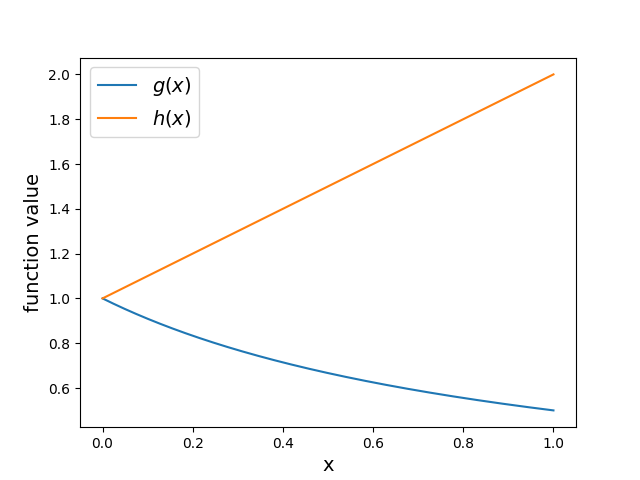

In [6]:
def plot_gh() -> None:
    x = np.linspace(0, 1, 1000)
    gval = g(x)
    hval = h(x)
    plt.figure()
    plt.plot(x, gval, '-', label=r'$g(x)$')
    plt.plot(x, hval, '-', label=r'$h(x)$')
    plt.xlabel('x', fontsize=14)
    plt.ylabel('function value', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
plot_gh()

Hmmm, they don't look similar. What is similar though? When one goes down, the other goes up! (They seem to be fairly correlated)

## Monte Carlo

For our comparison with control variates, we first compute a monte carlo estimate

In [7]:
num_samples = 1500
mc = monte_carlo(num_samples, np.random.rand, g)
MCerr = np.std(mc.evaluations) / np.sqrt(num_samples)  # estimated standard error from the same samples
print("Estimate = {:5f},\n Exact error = {:5e},\n MC Estimated Error = {:5e}".format(mc.estimate, np.abs(mc.estimate - exact), MCerr))


Estimate = 0.697375,
 Exact error = 4.22819163116939e-3,
 MC Estimated Error = 3.622185e-03


## Control variate

Lets now build a function for the control variate, and see what we can get

In [8]:
@dataclass
class ControlVariateEstimate:
    mc_g: MonteCarloEstimate
    mc_h: MonteCarloEstimate
    estimate: float
    weight: float
    cov: np.ndarray
    correlation: float

def control_variate(num_samples: int,
                    proposal_sample_generator: Callable[[int], np.ndarray],
                    g_evaluator: Callable[[np.ndarray], np.ndarray],
                    h_evaluator: Callable[[np.ndarray], np.ndarray],
                    h_mean: float,
                    cov: Optional[np.ndarray] = None) -> ControlVariateEstimate:
    """Perform control variate estimation.

    Args:

        num_samples: number of samples
        proposal_sample_generator: A function that generates samples with signature sample_generator(nsamples)
        g_evaluator: high-fidelity model outputting array (num_samples, 1)
        h_evaluator: low-fidelity model outputting array (num_samples, 1)
        h_mean: true mean
        cov: covariance matrix for g, h

    Returns:

        A self-normalized importance sampling estimator.
    """
    samples = proposal_sample_generator(num_samples)
    def get_samples(n):
        return samples
    mc_g = monte_carlo(num_samples, get_samples, g_evaluator)
    mc_h = monte_carlo(num_samples, get_samples, h_evaluator)

    if cov is None:
        cov = np.cov(mc_g.evaluations, mc_h.evaluations)
    corr = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    weight = - cov[0, 1] / cov[1, 1]
    estimate = mc_g.estimate + weight * (mc_h.estimate - h_mean)
    ret = ControlVariateEstimate(mc_g, mc_h, estimate, weight, cov, corr)
    return ret

Now we run the control variate scheme and look at the errors

In [9]:
num_samples = 1500
cv = control_variate(num_samples, np.random.rand, g, h, mean_h)
cv_err = np.sqrt(cv.cov[0, 0] / num_samples * (1 - cv.correlation**2))  # standard error
print("CV Estimate = {:5f}\n\tExact error = {:5e}\n\tCV Std Error = {:5e}".format(
    cv.estimate,
    np.abs(cv.estimate - exact),
    cv_err))
print("Correlation^2 = {:5e}\nCV-weight = {:5f}".format(cv.correlation**2, cv.weight))


CV Estimate = 0.693690
	Exact error = 5.43072896643682e-4
	CV Std Error = 6.439460e-04
Correlation^2 = 9.687742e-01
CV-weight = 0.477213


Lets recall the Monte Carlo Estimate

In [10]:
print(f"MC Estimate = {cv.mc_g.estimate:5f}\n\t"
      f"Exact error = {np.abs(cv.mc_g.estimate-exact):5e}\n\t"
      f"MC Estimated Error = {np.sqrt(cv.cov[0, 0] / num_samples):5e}")

MC Estimate = 0.691270
	Exact error = 1.87734508814830e-3
	MC Estimated Error = 3.644122e-03


We have achieved an estimate with almost an order of magnitude lower error! 

Lets generate many samples from both of these estimators and look at their distribution.

In [11]:
# First create two helper functions
def integrate_mc(nsamples: int) -> MonteCarloEstimate:
    return monte_carlo(nsamples, np.random.rand, g)
def integrate_cv(nsamples: int) -> ControlVariateEstimate:
    return control_variate(nsamples, np.random.rand, g, h, mean_h)

def compare_mc_cv(ntrials, nsamples):
    """Generate ntrials runs of monte carlo and control variate estimators, each estimator uses nsamples samples"""
    errs_mc = np.zeros((ntrials))
    errs_cv = np.zeros((ntrials))
    for ii in range(ntrials):
        errs_mc[ii] = integrate_mc(nsamples).estimate - exact
        errs_cv[ii] = integrate_cv(nsamples).estimate - exact
    return errs_mc, errs_cv

Std of Error with MC= 3.433921E-03
Std of Error with CV= 6.314982E-04


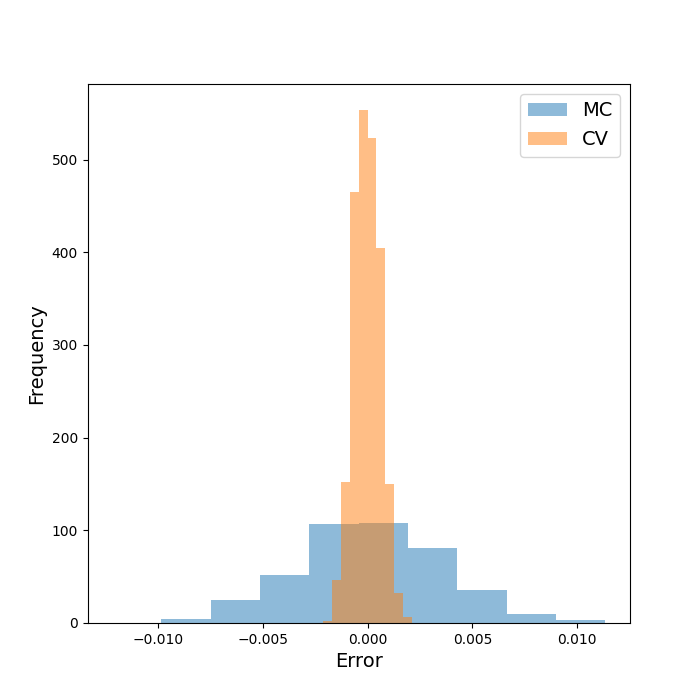

In [12]:
ntrials = 1000
nsamples = 1500
density = True
errs_mc, errs_cv = compare_mc_cv(ntrials, nsamples)
plt.figure(figsize=(7, 7))
plt.hist(errs_mc, label='MC', density=True, alpha=0.5)
plt.hist(errs_cv, label='CV', density=True, alpha=0.5)
plt.legend(fontsize=14)
plt.xlabel('Error', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
print("Std of Error with MC= {:5E}".format(np.std(errs_mc)))
print("Std of Error with CV= {:5E}".format(np.std(errs_cv)))
plt.show()

Lets take a look at how this histogram of the errors changes with number of samples

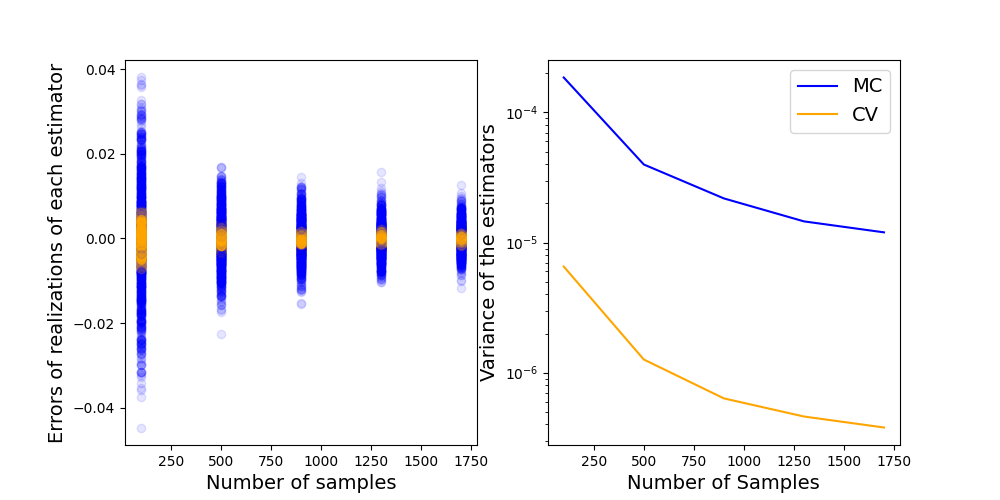

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ntrials = 1000
nsamples_range = np.arange(100, 2000, 400)
errs_mc = np.zeros((nsamples_range.shape[0], ntrials))
errs_cv = np.zeros((nsamples_range.shape[0], ntrials))
for ii, nsamp in enumerate(nsamples_range):
    errs_mc[ii, :], errs_cv[ii, :] = compare_mc_cv(ntrials, nsamp)

for ii in range(ntrials):
    ax1.plot(nsamples_range, errs_mc[:, ii], 'o', color='blue', alpha=0.1)
    ax1.plot(nsamples_range, errs_cv[:, ii], 'o', color='orange', alpha=0.5)
ax1.set_xlabel('Number of samples', fontsize=14)
ax1.set_ylabel('Errors of realizations of each estimator', fontsize=14)

ax2.semilogy(nsamples_range, np.var(errs_mc, axis=1), color='blue', label='MC')
ax2.semilogy(nsamples_range, np.var(errs_cv, axis=1), color='orange', label='CV')
ax2.set_xlabel('Number of Samples', fontsize=14)
ax2.set_ylabel('Variance of the estimators', fontsize=14)
plt.legend(fontsize=14)
plt.show()

Note that the rate of convergence (the variance) is the same! CV does not change the rate of convergence, it changes the constant.

### Is this the whole story? 

What about the computational cost? Suppose that each evaluation of $g$ costs 1 unit, and that each evaluation of $h$ costs $\epsilon>0$ units. Then if we require $N$ evaluations of $g$ and $N$ evaluations of $h$ the total cost of the CV method is $N(1 + \epsilon).$ It is not really fair to compare the variance of MC, which has a cost of $N$, with the variance of CV which has a cost of $N(1 + \epsilon)$. Instead, we should compare the variance for **equivalent numbers of evaluations of $g$**.

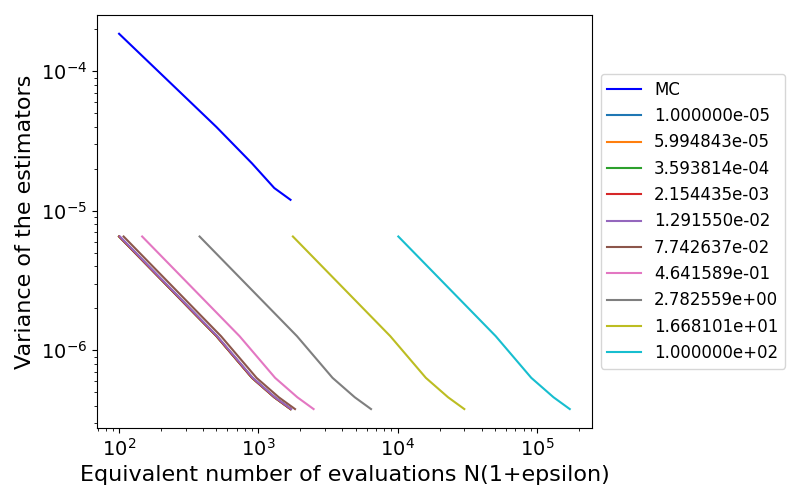

In [14]:
plt.figure(figsize=(8, 5))
# reference plot for monte carlo, the cost is NSAMPLES
plt.loglog(nsamples_range, np.var(errs_mc, axis=1), color='blue', label='MC')
# Now draw the CV errors while scaling the number of samples to the "equivalent number"
for epsilon in np.logspace(-5, 2, 10):
    plt.loglog(nsamples_range*(1+epsilon), np.var(errs_cv, axis=1), label=f"{epsilon:5e}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.xlabel('Equivalent number of evaluations N(1+epsilon)', fontsize=16)
plt.ylabel('Variance of the estimators', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

We see that the control variate estimator is more efficient than the Monte Carlo estimator for models $h$ that cost up to $16$ times MORE than $g.$ This occurs because control variates assume that the expectation of $h$ is known. Since $h$ and $g$ are highly correlated, all one needs is a couple of evaluations to fix the bias, and this information about the true mean of $h$ offsets the additional computational expense. Ofcourse as the cost of $h$ does continues to increase, the control variate does become more expensive. 

## Approximate control variates

In practice we choose $h$ for which we do not know the expectation, but that are significantly cheaper to evaluate. These could be simulations with coarser time/space discretization or simulations with simplified physics. In this case we have to also estimate this additional expectation, and this new estimator is the Approximate Control Variate (ACV)

\begin{equation}
S_{n,m}^{ACV}\left[g,h\right] = S_{n}\left[g\right] + \alpha\left( S_{n}\left[h\right] - S_{m}\left[h\right]\right)
\end{equation}

where the expectation of $h$ is also estimated via an $m$ sample Monte Carlo scheme. There are many variations of the ACV estimator, one of the most common is called the Multilevel Monte Carlo Scheme. 

*Please read the F19 Lecture 8 notes for the relevant details!*